In [2]:
# Standard imports
import matplotlib.pylab as plt
import torch
import os
import numpy as np
from pathlib import Path

# If you are running this notebook interactively
wdir = Path(os.path.abspath('')).parent.parent
os.chdir(wdir)

# gpytorch imports
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior

%matplotlib inline

# Setting manual seed for reproducibility
torch.manual_seed(73)
np.random.seed(73)

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)


In [3]:
import urllib.request
import tarfile

url = "http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/resources/3PhData.tar.gz"
urllib.request.urlretrieve(url, '3PhData.tar.gz')
with tarfile.open('3PhData.tar.gz', 'r') as f:
    f.extract('DataTrn.txt')
    f.extract('DataTrnLbls.txt')

Y = torch.Tensor(np.loadtxt(fname='DataTrn.txt'))
labels = torch.Tensor(np.loadtxt(fname='DataTrnLbls.txt'))
labels = (labels @ np.diag([1, 2, 3])).sum(axis=1)

In [6]:
from gpytorch.models.gplvm.latent_variable import *
from gpytorch.models.gplvm.bayesian_gplvm import BayesianGPLVM
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from gpytorch.means import ZeroMean
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal


def _init_pca(Y, latent_dim):
    U, S, V = torch.pca_lowrank(Y, q = latent_dim)
    return torch.nn.Parameter(torch.matmul(Y, V[:,:latent_dim]))


class bGPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, init_x=None):
        pca=False
        self.n = n
        self.batch_shape = torch.Size([data_dim])

        # Locations Z_{d} corresponding to u_{d}, they can be randomly initialized or
        # regularly placed with shape (D x n_inducing x latent_dim).
        self.inducing_inputs = torch.randn(data_dim, n_inducing, latent_dim)

        # Sparse Variational Formulation (inducing variables initialised as randn)
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(self, self.inducing_inputs, q_u, learn_inducing_locations=True)

        # Define prior for X
        X_prior_mean = torch.zeros(n, latent_dim)  # shape: N x Q
        prior_x = NormalPrior(X_prior_mean, torch.ones_like(X_prior_mean))

        if init_x is not None:
            print("Custom init_x")
            mu_init = torch.as_tensor(init_x['init_mu_x'], dtype=torch.float32)
            log_sigma2_init = torch.as_tensor(init_x['init_log_sigma2_x'], dtype=torch.float32)
            assert mu_init.shape == (n, latent_dim),         "init_x['init_mu_x'] has wrong shape"
            assert log_sigma2_init.shape == (n, latent_dim), "init_x['init_log_sigma2_x'] has wrong shape"

            std_init = (log_sigma2_init.exp()).sqrt()  # std = sqrt(exp(log_sigma2))

            X_init = torch.nn.Parameter(mu_init)
            X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)
            X._variational_std = torch.nn.Parameter(std_init)  # override std
        else:
            print("Default init_x")
            if pca:
                X_init = _init_pca(Y, latent_dim)
            else:
                X_init = torch.nn.Parameter(torch.randn(n, latent_dim))
            X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)

        # For (a) or (b) change to below:
        # X = PointLatentVariable(n, latent_dim, X_init)
        # X = MAPLatentVariable(n, latent_dim, X_init, prior_x)

        super().__init__(X, q_f)

        # Kernel (acting on latent dimensions)
        self.mean_module = ZeroMean(ard_num_dims=latent_dim)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)

In [7]:
N = len(Y)
data_dim = Y.shape[1]
latent_dim = data_dim
n_inducing = 25
pca = False

x_init = {
    "init_mu_x": np.random.randn(N, latent_dim).astype(np.float32),
    "init_log_sigma2_x": np.log(np.ones((N, latent_dim), dtype=np.float32))  # log(1) = 0
}

# Model
model = bGPLVM(N, data_dim, latent_dim, n_inducing, x_init)

# Likelihood
likelihood = GaussianLikelihood(batch_shape=model.batch_shape)

# Declaring the objective to be optimised along with optimiser
# (see models/latent_variable.py for how the additional loss terms are accounted for)
mll = VariationalELBO(likelihood, model, num_data=len(Y))

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)


# Training loop - optimises the objective wrt kernel hypers, variational params and inducing inputs
# using the optimizer provided.

loss_list = []
iterator = trange(10000 if not smoke_test else 4, leave=True)
batch_size = 100
for i in iterator:
    batch_index = model._get_batch_idx(batch_size)
    optimizer.zero_grad()
    sample = model.sample_latent_variable()  # a full sample returns latent x across all N
    sample_batch = sample[batch_index]
    output_batch = model(sample_batch)
    loss = -mll(output_batch, Y[batch_index].T).sum()
    loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),2))) + ", iter no: " + str(i))
    loss.backward()
    optimizer.step()

Custom init_x


  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Neg. ELBO Loss')

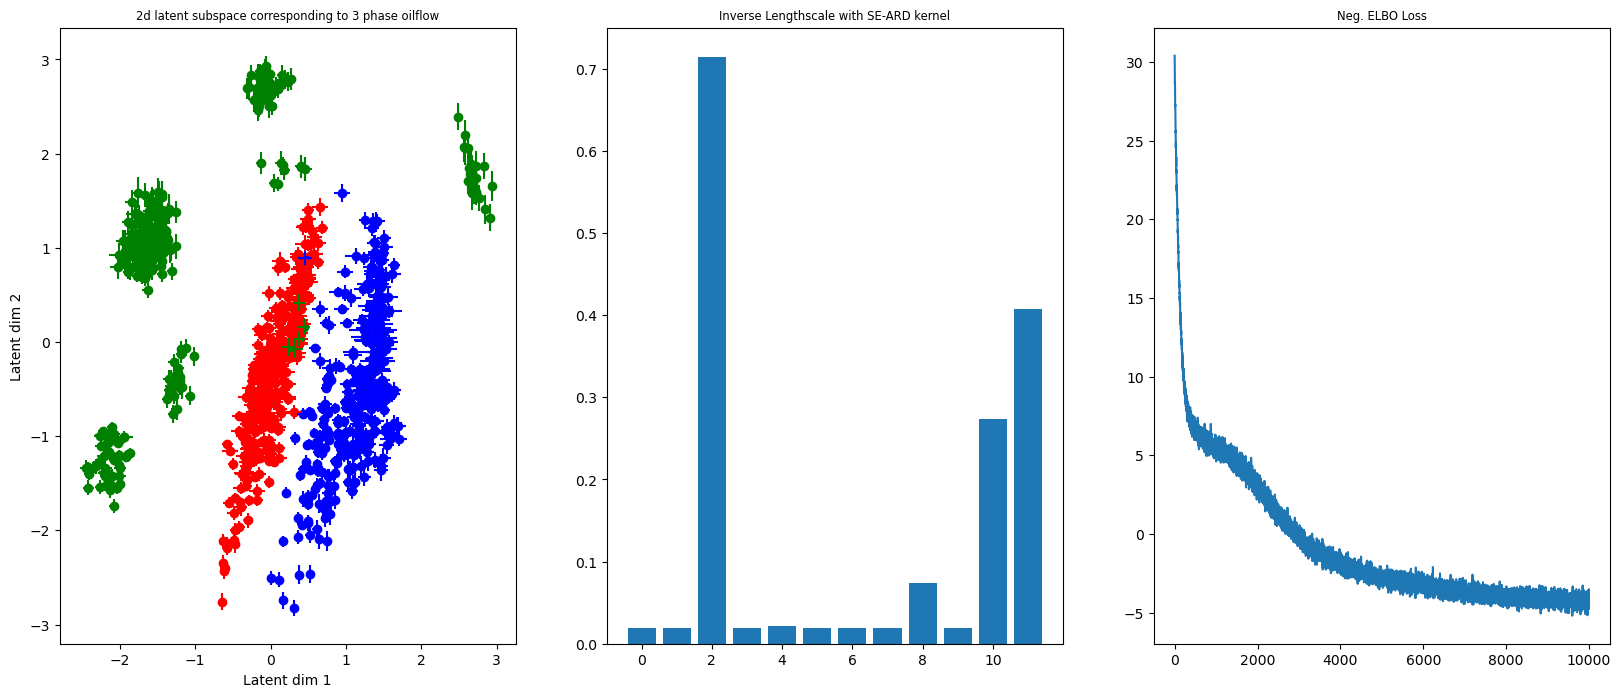

In [8]:
inv_lengthscale = 1 / model.covar_module.base_kernel.lengthscale
values, indices = torch.topk(model.covar_module.base_kernel.lengthscale, k=2,largest=False)

l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

plt.figure(figsize=(20, 8))
colors = ['r', 'b', 'g']

plt.subplot(131)
X = model.X.q_mu.detach().numpy()
std = torch.nn.functional.softplus(model.X.q_log_sigma).detach().numpy()
plt.title('2d latent subspace corresponding to 3 phase oilflow', fontsize='small')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')

# Select index of the smallest lengthscales by examining model.covar_module.base_kernel.lengthscales
for i, label in enumerate(np.unique(labels)):
    X_i = X[labels == label]
    scale_i = std[labels == label]
    plt.scatter(X_i[:, l1], X_i[:, l2], c=[colors[i]], label=label)
    plt.errorbar(X_i[:, l1], X_i[:, l2], xerr=scale_i[:,l1], yerr=scale_i[:,l2], label=label,c=colors[i], fmt='none')

plt.subplot(132)
plt.bar(np.arange(latent_dim), height=inv_lengthscale.detach().numpy().flatten())
plt.title('Inverse Lengthscale with SE-ARD kernel', fontsize='small')

plt.subplot(133)
plt.plot(loss_list, label='batch_size=100')
plt.title('Neg. ELBO Loss', fontsize='small')